# Инструменты для работы с языком 

... или зачем нужна предобработка.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10_Aehfbxgr3fxXPgI1gM5BTU8yOy-Z4U)

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2019-09-02 00:49:13--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2019-09-02 00:49:14--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37649f91af1c6d1425b11f3390.dl.dropboxusercontent.com/cd/0/inline/AnwT7H4-uyTASGZ29VMT2RHYRhpDNf3WuM8qDk9NhZbSO7SotuSOlGSglzkKpVeYdUWiT-euhVeq055N0wT8ytXNptLgh86nZAwtog6jxewocA/file# [following]
--2019-09-02 00:49:14--  https://uc37649f91af1c6d1425b11f3390.dl.dropboxusercontent.com/cd/0/inline/AnwT7H4-uyTASGZ29VMT2RHYRhpDNf3WuM8qDk9NhZbSO7SotuSOlGSglzkKpVeYdUWiT-euhVeq055N0wT8ytXNptLgh86nZAwtog6jxewocA/file
Resolving uc3764

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [12]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [7]:
from nltk import ngrams

In [8]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [9]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [10]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [11]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [13]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [14]:
list(vec.vocabulary_.items())[:10]

[('классным', 145519),
 ('адддд', 98275),
 ('vertu_dragon', 88391),
 ('покалечить', 187048),
 ('вмешался', 113304),
 ('неперевершений', 167001),
 ('ziqhqszh4i', 96622),
 ('налоговые', 163339),
 ('бытовухи', 109281),
 ('матово', 156797)]

In [15]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.76      0.75      0.76     28317
   positive       0.76      0.76      0.76     28392

avg / total       0.76      0.76      0.76     56709



Попробуем сделать то же самое для триграмм:

In [20]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.46      0.71      0.56     18138
   positive       0.82      0.61      0.70     38571

avg / total       0.71      0.64      0.65     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.73      0.76      0.74     26717
   positive       0.78      0.74      0.76     29992

avg / total       0.75      0.75      0.75     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## Токенизация

Токенизировать -- значит, поделить текст на слова, или *токены*.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [23]:
from nltk.tokenize import word_tokenize

In [24]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [25]:
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordTokenizer',
 'TweetTokenizer',
 'WhitespaceTokenizer',
 'WordPunctTokenizer']

Они умеют выдавать индексы начала и конца каждого токена:

In [26]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [27]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [28]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [29]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [30]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [31]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [32]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.80      0.76      0.78     29325
   positive       0.76      0.79      0.77     27384

avg / total       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [33]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [34]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ':(\n']


А можно получить грамматическую информацию:

In [35]:
mystem_analyzer.analyze(example)

[{'analysis': [{'gr': 'CONJ=', 'lex': 'но'}], 'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'gr': 'PART=', 'lex': 'не'}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)', 'lex': 'каждый'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,несов,пе=непрош,ед,изъяв,3-л', 'lex': 'хотеть'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'gr': 'SPRO,ед,сред,неод=(вин|им)', 'lex': 'что-то'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'gr': 'V,пе=инф,несов', 'lex': 'исправлять'}],
  'text': 'исправлять'},
 {'text': ':(\n'}]

Давайте терепь лемматизатор майстема в качестве токенизатора.

In [36]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [69]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [72]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'платили', 2368, 10),))]

In [82]:
ana[0].normal_form

'платить'

А теперь напишите аналогичную функцию для лемматизации с pymorphy2:

Что будет, если использовать её в качестве препроцессора? 

### mystem vs. pymorphy

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [24]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'text': 'сорока', 'analysis': [{'gr': 'NUM=(пр|дат|род|твор)', 'lex': 'сорок'}]}
{'text': 'Сорока', 'analysis': [{'gr': 'S,жен,од=им,ед', 'lex': 'сорока'}]}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [15]:
from collections import Counter

In [25]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2859142


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [26]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69267),
 ('и', 54916),
 ('в', 52853),
 ('я', 52506),
 ('RT', 38070),
 ('на', 35715),
 ('http', 32992),
 ('что', 31472),
 ('...', 28773),
 ('с', 27176)]

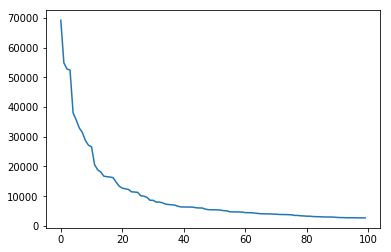

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [16]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       1.00      1.00      1.00     27764
   positive       1.00      1.00      1.00     28945

avg / total       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [37]:
cool_token = 
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       1.00      0.85      0.92     32733
   positive       0.83      1.00      0.91     23976

avg / total       0.93      0.91      0.91     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [39]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

   negative       0.99      1.00      1.00     27667
   positive       1.00      0.99      1.00     29042

avg / total       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

## Регулярки

(если осталось время)

Вообще, часто бывает так, что для конкретного случая нужен особый способ токенизации, и надо самостоятельно написать регулярку. Или, например, перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

In [2]:
import re

### findall
возвращает список всех найденных совпадений

In [6]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

### split
разделяет строку по заданному шаблону


In [7]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [8]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit = 2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [9]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярку, которая заменяет все цифры в строке на "DIG".

**Задание**: напишите регулярку, которая убирает url из строки.

### compile
компилирует регулярное выражение в отдельный объект

In [10]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

Если всё ещё осталось время: [регулярочный кроссворд ¯\_(ツ)_/¯](https://mariolurig.com/crossword/)